In [1]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from analysis import CellGraph, DataReader
from analysis import CurrentTrace

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import correlate
from statsmodels.tsa.arima.model import ARIMA

In [2]:
SIM_DIRECTORY_PREFIX = "../scripts/STANoMapping30000-24-05-2024-14-18-07/ComplexNp5Neu10"
NEXUS_INDEX = 379
SOMA_INDEX = 0
SIM_TIME = 20000

# seeds = [123]

In [3]:
# sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(123))
sim_directory = SIM_DIRECTORY_PREFIX
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
np.where(adj_matrix[379] > 0)[0]

array([380, 435])

## Cross-Correlation Analysis

In [20]:
ccm_nexus = []
ccm_basal = []

# for seed in seeds:
    # sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
v = DataReader.read_data(sim_directory, "v")
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# Compute axial currents
ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)
# ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data)

# Find indexes of apical branches (= nexus's children)
apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]

# # Compute correlations between currents
cross_corr_matrix = np.zeros((len(apical_branches), len(apical_branches), SIM_TIME))
for i in range(len(apical_branches)):
    for j in range(len(apical_branches)):
        cross_corr_matrix[i, j] = correlate(ac_matrix[NEXUS_INDEX, apical_branches[i]], ac_matrix[NEXUS_INDEX, apical_branches[j]])[SIM_TIME-1]#[SIM_TIME-1:]
ccm_nexus.append(cross_corr_matrix)

# Find indexes of soma's children
soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
basal_branches = seg_data.iloc[soma_children]
basal_branches = basal_branches[basal_branches.section == "dend"].index

cross_corr_matrix = np.zeros((len(basal_branches), len(basal_branches), SIM_TIME))
for i in range(len(basal_branches)):
    for j in range(len(basal_branches)):
        cross_corr_matrix[i, j] = correlate(ac_matrix[SOMA_INDEX, basal_branches[i]], ac_matrix[SOMA_INDEX, basal_branches[j]])[SIM_TIME-1]#[SIM_TIME-1:]
ccm_basal.append(cross_corr_matrix)

In [6]:
# ac_matrix[NEXUS_INDEX, apical_branches[0]]
# ac_matrix[NEXUS_INDEX, apical_branches[1]]
# correlate(ac_matrix[NEXUS_INDEX, apical_branches[1]], ac_matrix[NEXUS_INDEX, apical_branches[0]])
# correlate(ac_matrix[NEXUS_INDEX, apical_branches[1]], ac_matrix[NEXUS_INDEX, apical_branches[0]])[SIM_TIME-1:]

array([-0.        ,  0.04994554,  0.08121656, ...,  0.07864672,
        0.07502262,  0.0669472 ])

In [27]:
len(ccm_nexus)

1

In [26]:
ccm_nexus[0].shape

(2, 2, 20000)

In [37]:
ccm_nexus[0][0][0]

array([0.00080137, 0.00080137, 0.00080137, ..., 0.00080137, 0.00080137,
       0.00080137])

In [28]:
# ac_matrix[NEXUS_INDEX].shape

(643, 10001)

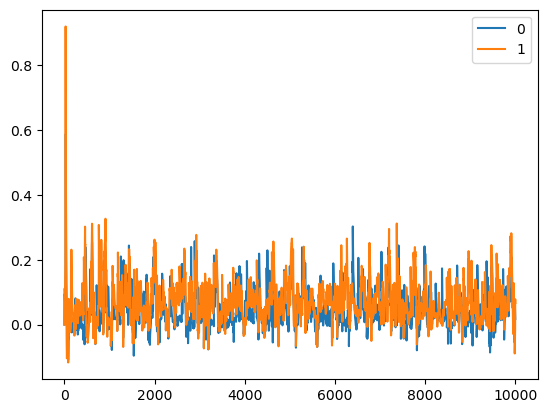

In [31]:
for i in range(len(apical_branches)):
    plt.plot(ac_matrix[NEXUS_INDEX, apical_branches[i]], label = str(i))
plt.legend()

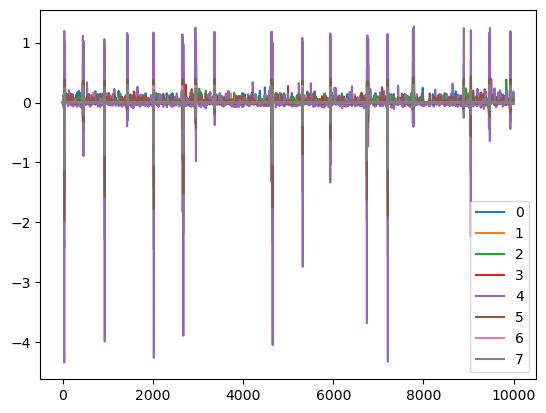

In [32]:
for i in range(len(basal_branches)):
    plt.plot(ac_matrix[SOMA_INDEX, basal_branches[i]], label = str(i))
plt.legend()

In [33]:
ccm_nexus_all = np.stack(ccm_nexus)
np.argmax(np.mean(ccm_nexus_all, axis = 0), axis = -1)

array([[0, 0],
       [0, 0]])

In [38]:
ccm_soma_all = np.stack(ccm_basal)
np.argmax(np.mean(ccm_soma_all, axis = 0), axis = -1)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

## ARIMA Analysis

In [39]:
# https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions
Z_nexus = []
Z_basal = []

# for seed in seeds:
    # sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

# Read data
v = DataReader.read_data(sim_directory, "v")
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# Compute axial currents
ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

# Find indexes of apical branches (= nexus's children)
apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]

# Estimate ARIMAs between currents
Z_matrix = np.zeros((len(apical_branches), len(apical_branches), 5))
for i in range(len(apical_branches)):
    for j in range(len(apical_branches)):
        model1 = ARIMA(ac_matrix[NEXUS_INDEX, apical_branches[i]], order = (2, 0, 2))
        res1 = model1.fit()
        model2 = ARIMA(ac_matrix[NEXUS_INDEX, apical_branches[j]], order = (2, 0, 2))
        res2 = model2.fit()
        Z = (res1.params - res2.params) / np.sqrt(np.diag(res1.cov_params()) + np.diag(res2.cov_params()))
        Z_matrix[i, j] = Z[:-1]
Z_nexus.append(Z_matrix)

# Find indexes of soma's children
soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
basal_branches = seg_data.iloc[soma_children]
basal_branches = basal_branches[basal_branches.section == "dend"].index

Z_matrix = np.zeros((len(basal_branches), len(basal_branches), 5))
for i in range(len(basal_branches)):
    for j in range(len(basal_branches)):
        model1 = ARIMA(ac_matrix[SOMA_INDEX, basal_branches[i]], order = (2, 0, 2))
        res1 = model1.fit()
        model2 = ARIMA(ac_matrix[SOMA_INDEX, basal_branches[j]], order = (2, 0, 2))
        res2 = model2.fit()
        Z = (res1.params - res2.params) / np.sqrt(np.diag(res1.cov_params()) + np.diag(res2.cov_params()))
        Z_matrix[i, j] = Z[:-1]
Z_basal.append(Z_matrix)

/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dr

In [40]:
Z_nexus_all = np.stack(Z_nexus)
Z_nexus_all_avg = np.mean(Z_nexus_all, axis = 0)
np.sum(np.abs(Z_nexus_all_avg) < 1.96, axis = -1) / 5

array([[1. , 0.8],
       [0.8, 1. ]])

In [41]:
Z_basal_all = np.stack(Z_basal)
Z_basal_all_avg = np.mean(Z_basal_all, axis = 0)
np.sum(np.abs(Z_basal_all_avg) < 1.96, axis = -1) / 5

array([[1. , 0. , 0.6, 0.2, 1. , 0.4, 0.4, 0.8],
       [0. , 1. , 0. , 0.2, 0.6, 0. , 0.2, 1. ],
       [0.6, 0. , 1. , 0.6, 0.8, 1. , 0.4, 0.8],
       [0.2, 0.2, 0.6, 1. , 0.8, 0.6, 0.6, 1. ],
       [1. , 0.6, 0.8, 0.8, 1. , 0.8, 0.8, 1. ],
       [0.4, 0. , 1. , 0.6, 0.8, 1. , 0.4, 0.8],
       [0.4, 0.2, 0.4, 0.6, 0.8, 0.4, 1. , 1. ],
       [0.8, 1. , 0.8, 1. , 1. , 0.8, 1. , 1. ]])

## Generating currents based on ARIMA

In [42]:
# seed = 123
# sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

# Read data
v = DataReader.read_data(sim_directory, "v")
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# Compute axial currents
ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

# Find indexes of apical branches (= nexus's children)
apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]

models = []
for i in range(len(apical_branches)):
    model = ARIMA(ac_matrix[NEXUS_INDEX, apical_branches[i]], order = (4, 0, 5))
    models.append(model.fit())

/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
def generate_trace_with_model(model, size):
    np.random.seed(123)
    const = model.params[0]
    ar = model.params[1:5]
    ma = model.params[5:-1]
    sigma = model.params[-1]
    out = [0, -0.        ,  0.03531086,  0.05447467]
    for _ in range(size):
        pred = const + np.sum(ar.T * np.array(out[-4:]))
        out.append(pred)
    return out

In [44]:
print(np.round(models[0].params, 3))
models[0].summary()

[0.041 0.114 0.135 0.255 0.349 1.034 0.88  0.555 0.132 0.035 0.   ]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10001
Model:                 ARIMA(4, 0, 5)   Log Likelihood               28752.522
Date:                Fri, 24 May 2024   AIC                         -57483.043
Time:                        15:59:44   BIC                         -57403.728
Sample:                             0   HQIC                        -57456.196
                              - 10001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0412      0.005      8.844      0.000       0.032       0.050
ar.L1          0.1143      1.452      0.079      0.937      -2.731       2.960
ar.L2          0.1346      1.183      0.114      0.909      -2.183       2.453
ar.L3          0.2549      0.869      0.293      0.769      -1.449       1.959
ar.L4          0.3493      0.947      0.369      0.712      -1.506       2.205
ma.L1          1.0335      1.452      0.712      0.477      -1.812       3.879
ma.L2          0.8798      0.714      1.233      0.218      -0.519       2.279
ma.L3          0.5549      1.123      0.494      0.621      -1.647       2.756
ma.L4          0.1318      0.221      0.596      0.551      -0.302       0.565
ma.L5          0.0348      0.071      0.492      0.623      -0.104       0.174
sigma2         0.0002   5.46e-07    340.494      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           3094909.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             6.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

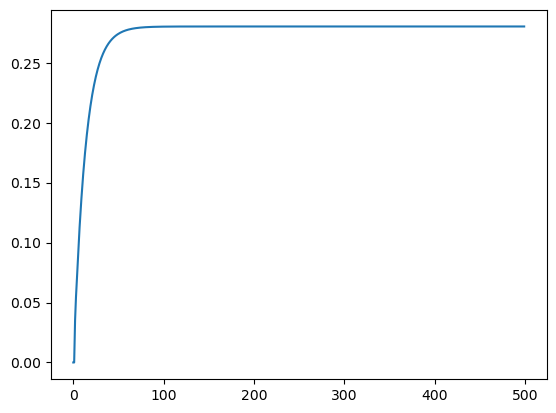

In [45]:
out = generate_trace_with_model(models[0], 2000)
plt.plot(out[:500])

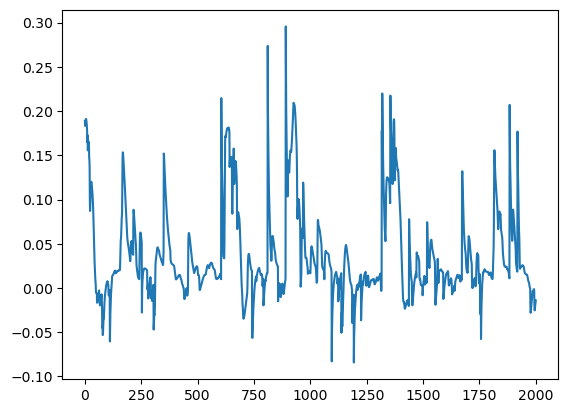

In [46]:
nm = models[0].append(models[0].predict(0, 9) + np.random.normal(0, 1, 10))
plt.plot(nm.predict(2000, 4000))

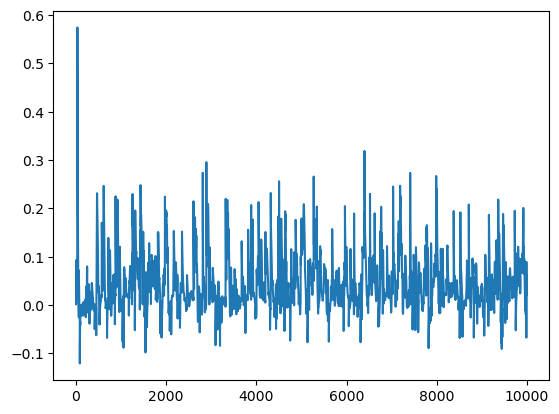

In [47]:
plt.plot(models[0].predict())

380 0.04493541626822276 0.05439629858135963


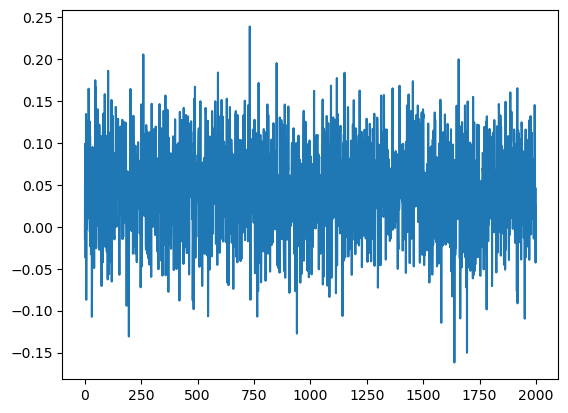

In [48]:
np.random.seed(123)
trace = ac_matrix[NEXUS_INDEX, apical_branches[0]]
plt.plot(np.random.normal(np.mean(trace), np.std(trace), 2000))
print(apical_branches[0], np.mean(trace), np.std(trace))

## (?) Magnitude Analysis

In [50]:
magn_apic = []
magn_apic_trunk = []
magn_basal = []

# for seed in seeds:
#     sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

# Read data
v = DataReader.read_data(sim_directory, "v")
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# Compute axial currents
ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

# Find indexes of apical branches (= nexus's children)
apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
magn_apic.append(np.abs(ac_matrix[apical_branches]))

# Find indexes of soma's children
soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
basal_branches = seg_data.iloc[soma_children]
basal_branches = basal_branches[basal_branches.section == "dend"].index
magn_basal.append(np.abs(ac_matrix[basal_branches]))

apic_trunk = seg_data.iloc[soma_children]
apic_trunk = apic_trunk[apic_trunk.section == "apic"].index
magn_apic_trunk.append(np.abs(ac_matrix[apic_trunk]))

In [52]:
magn_apic_all = np.stack(magn_apic)
magn_apic_trunk_all = np.stack(magn_apic_trunk)
magn_basal_all = np.stack(magn_basal)

In [53]:
plt.plot(np.abs(ac_matrix[0]), label = 'soma')
plt.plot(np.sum(np.mean(magn_apic_all, axis = 0), axis = 0), label = 'apic')
plt.plot(np.sum(np.mean(magn_apic_trunk_all, axis = 0), axis = 0), label = 'trunk')
plt.plot(np.sum(np.mean(magn_basal_all, axis = 0), axis = 0), label = 'basal')
plt.legend()

/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 534x837892 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

 ...]

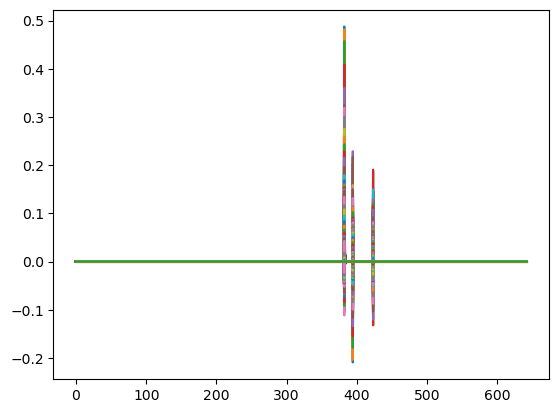

In [54]:
plt.plot(ac_matrix[381])
plt.plot(ac_matrix[393])
plt.plot(ac_matrix[422])

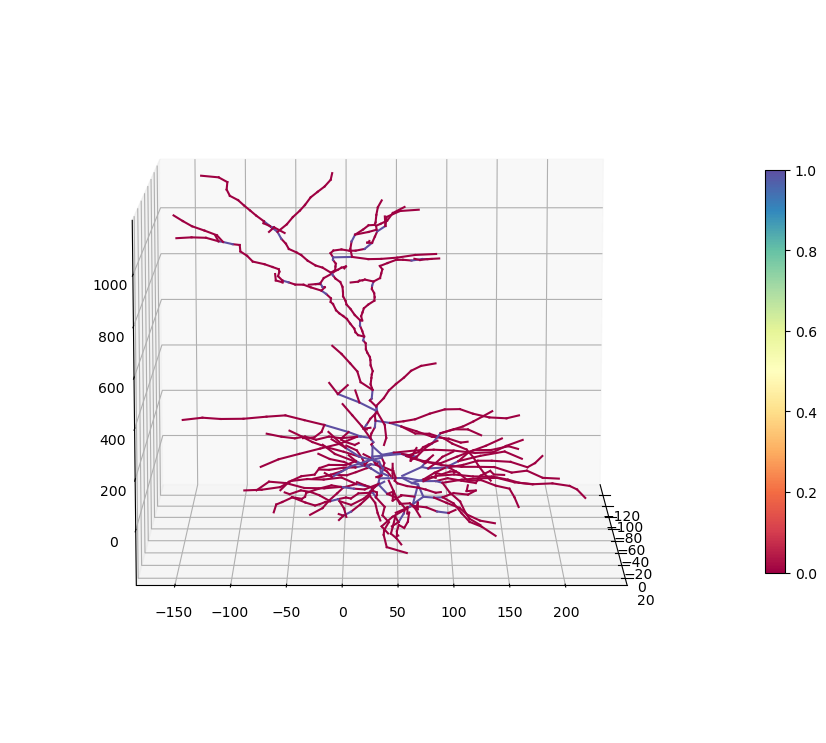

In [55]:
cg = CellGraph(seg_data)
colors = np.zeros(len(seg_data))
colors[np.where(np.sum(adj_matrix, axis = 1) > 1)[0]] = 1
fig = cg.plot_cell(color = colors)
plt.figsize = (10, 30)
ax = fig.gca()
ax.view_init(elev = 10, azim = 0)